In [1]:
import os, sys, numpy as np, pandas as pd, matplotlib
import matplotlib.pyplot as plt

In [2]:
# === DATA CLEANING (sel baru, aman) ===
import os, re, numpy as np, pandas as pd

if 'df' in globals() and isinstance(df, pd.DataFrame):
    _raw = df.copy()
else:
    DATA_PATH = globals().get('DATA_PATH', '/kaggle/input/co-emissions-across-countries-regions-and-sectors/Data.csv')
    assert os.path.exists(DATA_PATH), f"File tidak ditemukan: {DATA_PATH}"
    _raw = pd.read_csv(DATA_PATH)

df_clean = _raw.copy()

str_cols = [c for c in df_clean.columns if df_clean[c].dtype == 'object']
for c in str_cols:
    df_clean[c] = df_clean[c].astype(str).str.strip()

if 'description' in df_clean.columns:
    df_clean['description'] = df_clean['description'].str.lower().str.strip()

if 'year' in df_clean.columns:
    df_clean['year'] = pd.to_numeric(df_clean['year'], errors='coerce').astype('Int64')

def looks_numeric(s):
    if not isinstance(s, str): return False
    return bool(re.fullmatch(r"[-+]?[\d,\.]+", s))

candidate_num = []
for c in df_clean.columns:
    if c == 'year': continue
    if df_clean[c].dtype == 'object':
        sample = df_clean[c].dropna().astype(str).head(100).tolist()
        if sample:
            pct_numeric = np.mean([looks_numeric(x) for x in sample])
            if pct_numeric >= 0.5:
                candidate_num.append(c)

for c in candidate_num:
    df_clean[c] = df_clean[c].str.replace(',', '', regex=False).str.replace(' ', '', regex=False)
    df_clean[c] = pd.to_numeric(df_clean[c], errors='coerce')

subset_keys = [k for k in ['name','year'] if k in df_clean.columns]
if len(subset_keys) == 2:
    df_clean = df_clean.sort_values(['name','year']).drop_duplicates(subset=subset_keys, keep='last')

for col in ['population','gdp','primary_energy_consumption']:
    if col in df_clean.columns:
        df_clean.loc[df_clean[col] < 0, col] = np.nan

if {'gdp','population'}.issubset(df_clean.columns):
    df_clean['gdp_per_capita_calc'] = df_clean['gdp'] / df_clean['population']

if {'co2','co2_including_luc'}.issubset(df_clean.columns):
    df_clean['luc_gap'] = df_clean['co2_including_luc'] - df_clean['co2']
    df_clean['luc_share'] = np.where(df_clean['co2_including_luc'] != 0,
                                     df_clean['luc_gap'] / df_clean['co2_including_luc'], np.nan)

SAVE_PATH = '/kaggle/working/co2_country_clean.csv'
df_clean.to_csv(SAVE_PATH, index=False)

print("✅ Cleaning selesai!")
print(f"Rows: {df_clean.shape[0]} | Columns: {df_clean.shape[1]}")
print(f"Saved to: {SAVE_PATH}")


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


✅ Cleaning selesai!
Rows: 43746 | Columns: 83
Saved to: /kaggle/working/co2_country_clean.csv


In [3]:
# 1) Pilih sumber data kerja (df_clean jika ada; jika tidak df)
_df = (df_clean.copy()
       if 'df_clean' in globals() and isinstance(df_clean, pd.DataFrame)
       else df.copy())

# 2) Filter hanya country jika kolom 'description' ada
if 'description' in _df.columns:
    _df = _df[_df['description'].astype(str).str.lower().eq('country')].copy()

# 3) Pastikan 'year' numerik
if 'year' not in _df.columns:
    raise KeyError("Kolom 'year' tidak ditemukan pada dataset.")
_df['year'] = pd.to_numeric(_df['year'], errors='coerce').astype('Int64')

# 4) Auto-deteksi kolom nama negara
NAME_CANDIDATES = ['name', 'Name', 'entity', 'country']
NAME_COL = next((c for c in NAME_CANDIDATES if c in _df.columns), None)
if NAME_COL is None:
    raise KeyError(f"Tidak menemukan kolom penanda negara. Coba salah satu: {NAME_CANDIDATES}")

# 5) Buat gdp_per_capita_calc jika memungkinkan
if 'gdp_per_capita_calc' not in _df.columns:
    if {'gdp','population'}.issubset(_df.columns):
        _df['gdp_per_capita_calc'] = np.where(
            _df['gdp'].notna() & _df['population'].notna() & (_df['population'] > 0),
            _df['gdp'] / _df['population'], np.nan
        )
    else:
        _df['gdp_per_capita_calc'] = np.nan

# 6) Pilih ANALYSIS_YEAR: tahun dengan ketersediaan data terbanyak.
#    Prioritas: (co2 & gdp) → jika tidak, pakai co2 saja.
if {'co2','gdp'}.issubset(_df.columns):
    pool = _df.dropna(subset=['co2','gdp'])
elif 'co2' in _df.columns:
    pool = _df.dropna(subset=['co2'])
else:
    raise KeyError("Kolom 'co2' tidak tersedia untuk pemilihan tahun analisis.")

# Jika pool kosong, fallback ke tahun max yang punya co2
if pool.empty:
    if 'co2' in _df.columns:
        ANALYSIS_YEAR = int(_df[_df['co2'].notna()]['year'].max())
    else:
        ANALYSIS_YEAR = int(_df['year'].max())
else:
    year_counts = pool.groupby('year').size().sort_values(ascending=False)
    ANALYSIS_YEAR = int(year_counts.index[0])

print("ANALYSIS_YEAR:", ANALYSIS_YEAR)

# 7) Subset data di tahun analisis
df_y = _df[_df['year'] == ANALYSIS_YEAR].copy()
print("Rows pada tahun analisis:", df_y.shape)

# 8) Tampilkan sampel kolom-kolom penting (yang tersedia saja)
cols_interest_all = [
    'co2','co2_per_capita','co2_per_gdp','energy_per_gdp',
    'primary_energy_consumption','population','gdp','gdp_per_capita_calc'
]
cols_present = [c for c in cols_interest_all if c in df_y.columns]

if cols_present:
    display(df_y[[NAME_COL] + cols_present].head(10))
else:
    display(df_y[[NAME_COL]].head(10))

# 9) Ranking efisiensi (co2_per_gdp) jika ada
if 'co2_per_gdp' in df_y.columns:
    ranked = df_y[[NAME_COL, 'co2_per_gdp']].dropna().sort_values('co2_per_gdp')
    print("Top-10 paling efisien (CO₂/GDP terendah):")
    display(ranked.head(10).rename(columns={NAME_COL: 'name'}))
    print("Top-10 paling boros (CO₂/GDP tertinggi):")
    display(ranked.tail(10).rename(columns={NAME_COL: 'name'}))
else:
    print("Kolom 'co2_per_gdp' tidak tersedia — lewati ranking efisiensi.")

ANALYSIS_YEAR: 2022
Rows pada tahun analisis: (253, 83)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Name,co2,co2_per_capita,co2_per_gdp,energy_per_gdp,primary_energy_consumption,population,gdp,gdp_per_capita_calc
172,Afghanistan,10.558,0.260,0.198,NaN,NaN,40578846.0,5.330347e+10,1313.577822
346,Albania,5.173,1.830,0.143,NaN,NaN,2827615.0,3.617101e+10,12792.054771
520,Algeria,184.558,4.058,0.310,1.232,734.191,45477391.0,5.958200e+11,13101.455182
694,Andorra,0.420,5.263,NaN,NaN,NaN,79722.0,NaN,NaN
868,Angola,20.250,0.568,0.128,NaN,NaN,35635028.0,1.583460e+11,4443.549195
1042,Antigua and Barbuda,0.618,6.657,NaN,NaN,NaN,92851.0,NaN,NaN
1216,Argentina,204.081,4.494,0.239,1.204,1029.381,45407904.0,8.549140e+11,18827.427049
1390,Armenia,7.165,2.487,0.180,NaN,NaN,2880883.0,3.972173e+10,13788.041425
1564,Australia,384.362,14.670,0.286,1.236,1661.016,26200987.0,1.344250e+12,51305.319147
1738,Austria,61.489,6.783,0.154,0.952,379.769,9064679.0,3.988150e+11,43996.593812


Top-10 paling efisien (CO₂/GDP terendah):


,name,co2_per_gdp
8176,Democratic Republic of Congo,0.051
25575,Rwanda,0.054
32187,Uganda,0.055
10438,Ethiopia,0.056
29925,Switzerland,0.059
18267,Malawi,0.066
5740,Central African Republic,0.072
29751,Sweden,0.076
4870,Burundi,0.077
29229,Sri Lanka,0.078


Top-10 paling boros (CO₂/GDP tertinggi):


,name,co2_per_gdp
14092,Iran,0.509
28533,South Africa,0.560
33753,Venezuela,0.585
2260,Bahrain,0.607
17397,Libya,0.629
31839,Turkmenistan,0.658
17049,Lesotho,0.805
31317,Trinidad and Tobago,0.968
20355,Mongolia,0.969
22617,North Korea,1.388


# ---------- Setup ----------

In [4]:
# GANTI path sesuai lokasi file
DATA_PATH = "/kaggle/working/co2_country_clean.csv"  # hasil dari EDA kamu
assert os.path.exists(DATA_PATH), f"File tidak ditemukan: {DATA_PATH}"

pd.set_option("display.max_columns", 120)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__, "| numpy:", np.__version__, "| matplotlib:", matplotlib.__version__)
print("DATA_PATH:", DATA_PATH)

def savefig(path, dpi=140, bbox_inches="tight"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.savefig(path, dpi=dpi, bbox_inches=bbox_inches)

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head(5))

Python: 3.11.13
pandas: 2.2.3 | numpy: 1.26.4 | matplotlib: 3.7.2
DATA_PATH: /kaggle/working/co2_country_clean.csv
Shape: (43746, 83)


,Description,Name,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,co2_including_luc,co2_including_luc_growth_abs,co2_including_luc_growth_prct,co2_including_luc_per_capita,co2_including_luc_per_gdp,co2_including_luc_per_unit_energy,co2_per_capita,co2_per_gdp,co2_per_unit_energy,coal_co2,coal_co2_per_capita,consumption_co2,consumption_co2_per_capita,consumption_co2_per_gdp,cumulative_cement_co2,cumulative_co2,cumulative_co2_including_luc,cumulative_coal_co2,cumulative_flaring_co2,cumulative_gas_co2,cumulative_luc_co2,cumulative_oil_co2,cumulative_other_co2,energy_per_capita,energy_per_gdp,flaring_co2,flaring_co2_per_capita,gas_co2,gas_co2_per_capita,ghg_excluding_lucf_per_capita,ghg_per_capita,land_use_change_co2,land_use_change_co2_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,oil_co2,oil_co2_per_capita,other_co2_per_capita,other_industry_co2,primary_energy_consumption,share_global_cement_co2,share_global_co2,share_global_co2_including_luc,share_global_coal_co2,share_global_cumulative_cement_co2,share_global_cumulative_co2,share_global_cumulative_co2_including_luc,share_global_cumulative_coal_co2,share_global_cumulative_flaring_co2,share_global_cumulative_gas_co2,share_global_cumulative_luc_co2,share_global_cumulative_oil_co2,share_global_cumulative_other_co2,share_global_flaring_co2,share_global_gas_co2,share_global_luc_co2,share_global_oil_co2,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share,gdp_per_capita_calc,luc_gap,luc_share
0,Country,Afghanistan,1850,AFG,"3,752,993.0000",NaN,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,2.9930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1680,1.9810,2.9930,0.7970,3.5950,0.9580,0.2240,0.0600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1130,NaN,NaN,NaN,NaN,0.1130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.4360,0.6290,NaN,NaN,NaN,NaN,NaN
1,Country,Afghanistan,1851,AFG,"3,767,956.0000",NaN,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,6.0080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1680,1.9900,3.0150,0.8000,3.6150,0.9590,0.2290,0.0610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1100,NaN,NaN,NaN,NaN,0.1070,NaN,NaN,0.1560,0.0000,0.0000,0.0000,0.0000,7.5000,0.6330,NaN,NaN,NaN,NaN,NaN
2,Country,Afghanistan,1852,AFG,"3,783,940.0000",NaN,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,9.0430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1680,1.9980,3.0350,0.8020,3.6350,0.9610,0.2340,0.0620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1090,NaN,NaN,NaN,NaN,0.1060,NaN,NaN,0.1550,0.0000,0.0000,0.0000,0.0000,7.5600,0.6370,NaN,NaN,NaN,NaN,NaN
3,Country,Afghanistan,1853,AFG,"3,800,954.0000",NaN,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,12.0950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1690,2.0050,3.0520,0.8030,3.6560,0.9620,0.2380,0.0630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1080,NaN,NaN,NaN,NaN,0.1050,NaN,NaN,0.1550,0.0000,0.0000,0.0000,0.0000,7.6200,0.6410,NaN,NaN,NaN,NaN,NaN
4,Country,Afghanistan,1854,AFG,"3,818,038.0000",NaN,0.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,15.1620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1690,2.0110,3.0670,0.8030,3.6760,0.9630,0.2420,0.0630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1070,NaN,NaN,NaN,NaN,0.1050,NaN,NaN,0.1550,0.0000,0.0000,0.0000,0.0000,7.6780,0.6440,NaN,NaN,NaN,NaN,NaN


In [5]:
# ==== SUPER FIX: satukan kolom duplikat (termasuk 'year') dan normalisasi ====
import pandas as pd, numpy as np, re

def normalize_dedupe_columns(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()

    # 0) Flatten MultiIndex jika ada
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ["_".join([str(x) for x in tup if str(x)!=""]) for tup in df.columns]

    # 1) Rapikan header
    df.columns = pd.Index([str(c).replace("\n"," ").strip() for c in df.columns])

    # 2) Normalizer label untuk pengelompokan duplikat semantik
    def norm(s: str) -> str:
        s = str(s).replace("\u00a0"," ").strip()
        return re.sub(r"[\s\.\-\(\)\[\]0-9]+", "", s, flags=re.IGNORECASE).lower()

    groups = {}
    for c in df.columns:
        groups.setdefault(norm(c), []).append(c)

    # 3) Gabungkan tiap grup duplikat → ambil nilai valid pertama per baris
    def combine_block(block: pd.DataFrame) -> pd.Series:
        return block.bfill(axis=1).iloc[:, 0]

    for key, cols in groups.items():
        if len(cols) <= 1:
            continue
        block = df.loc[:, cols].copy()

        # Coerce numeric utk kolom-kolom numerik umum
        if key in {"year","co2","gdp","population","energypergdp","co2pergdp"}:
            for cc in block.columns:
                block[cc] = pd.to_numeric(block[cc], errors="coerce")

        combined = combine_block(block)

        # Hapus semua kolom lama, ganti dengan satu kolom "cantik"
        df.drop(columns=cols, inplace=True, errors="ignore")
        new_name = {
            "year": "year",
            "name": "name",
            "entity": "name",
            "country": "name"
        }.get(key, cols[0])

        if new_name in df.columns:
            # hindari tabrakan nama
            i = 2
            base = new_name
            while new_name in df.columns:
                new_name = f"{base}_{i}"
                i += 1
        df[new_name] = combined

    # 4) Jika masih ada header duplikat, beri suffix otomatis
    if pd.Series(df.columns).duplicated().any():
        df.columns = pd.io.parsers.ParserBase({"names": df.columns})._maybe_dedup_names(df.columns)

    # 5) Pastikan 'year' ada & numerik
    if "year" not in df.columns:
        # cari kandidat yg ternormalisasi = 'year'
        yr_cands = [c for c in df.columns if norm(c) == "year"]
        if yr_cands:
            df.rename(columns={yr_cands[0]: "year"}, inplace=True)
        else:
            raise KeyError("Kolom 'year' tidak ditemukan setelah normalisasi.")
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

    # 6) Pastikan ada 'name' (gabungkan entity/country/Name jika perlu)
    if "name" not in df.columns:
        cands = [c for c in ["Name","entity","country"] if c in df.columns]
        if cands:
            comb = df[cands].astype(str).replace({"nan": np.nan}).bfill(axis=1).iloc[:,0]
            df.drop(columns=cands, inplace=True)
            df["name"] = comb

    return df

# ==== PAKAI FIXER ====
df = normalize_dedupe_columns(df)

# Cek cepat
assert not pd.Series(df.columns).duplicated().any(), "Masih ada header duplikat."
print("✅ Selesai. 'year' unik & numerik. Rentang:",
      (int(df['year'].min()) if df['year'].notna().any() else 'NA'), "→",
      (int(df['year'].max()) if df['year'].notna().any() else 'NA'))
print("Kolom nama negara:", "name" if "name" in df.columns else "N/A")


✅ Selesai. 'year' unik & numerik. Rentang: 1850 → 2023
Kolom nama negara: name


In [6]:
COUNTRY = "Indonesia"
df_id = _df[_df[NAME_COL] == COUNTRY].copy()


In [7]:
# pastikan tipe
if "year" in df.columns:
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

# subset country saja (harusnya file ini sudah country-only, cek jaga-jaga)
if "description" in df.columns:
    df = df[df["description"].str.lower()=="country"].copy() if "description" in df.columns else df.copy()

# negara yang akan difokuskan
COUNTRY = "Indonesia"

# ====================================================
# 1) Derive metrics: efisiensi & intensitas emisi
# ====================================================

In [8]:
# 1) Pilih dataframe kerja (pakai df_clean kalau ada; kalau tidak pakai df)
_df = df_clean.copy() if 'df_clean' in globals() and isinstance(df_clean, pd.DataFrame) else df.copy()

# 2) Cari kolom nama negara yang tersedia
NAME_CANDIDATES = ["name", "Name", "entity", "country"]
NAME_COL = next((c for c in NAME_CANDIDATES if c in _df.columns), None)
if NAME_COL is None:
    raise KeyError(f"Tidak menemukan kolom nama negara. Coba cek salah satu dari: {NAME_CANDIDATES}")

# 3) Pastikan kolom 'year' numerik
if "year" in _df.columns:
    _df["year"] = pd.to_numeric(_df["year"], errors="coerce").astype("Int64")
else:
    raise KeyError("Kolom 'year' tidak ditemukan.")

# 4) Hitung gdp_per_capita_calc kalau belum ada
if "gdp_per_capita_calc" not in _df.columns:
    if {"gdp","population"}.issubset(_df.columns):
        _df["gdp_per_capita_calc"] = np.where(
            _df["gdp"].notna() & _df["population"].notna() & (_df["population"]>0),
            _df["gdp"]/ _df["population"], np.nan
        )
    else:
        _df["gdp_per_capita_calc"] = np.nan

# 5) Tentukan tahun analisis: tahun dengan data co2 & gdp terbanyak (fallback: co2 terbanyak)
has_cols = set(_df.columns)
if {"co2","gdp"}.issubset(has_cols):
    candidates = _df.dropna(subset=["co2","gdp"])
elif "co2" in has_cols:
    candidates = _df.dropna(subset=["co2"])
else:
    raise KeyError("Kolom 'co2' tidak ditemukan untuk pemilihan tahun analisis.")

yr_counts = candidates.groupby("year").size().sort_values(ascending=False)
if len(yr_counts)==0:
    # fallback ke tahun maksimum yang punya co2
    ANALYSIS_YEAR = int(_df[_df["co2"].notna()]["year"].max())
else:
    ANALYSIS_YEAR = int(yr_counts.index[0])

print("ANALYSIS_YEAR:", ANALYSIS_YEAR)

# 6) Subset tahun analisis
df_y = _df[_df["year"]==ANALYSIS_YEAR].copy()
print("Rows pada tahun analisis:", df_y.shape)

# 7) Siapkan kolom yang ingin ditampilkan (hanya yang ada)
cols_interest_all = ["co2","co2_per_capita","co2_per_gdp","energy_per_gdp",
                     "primary_energy_consumption","population","gdp","gdp_per_capita_calc"]
cols_present = [c for c in cols_interest_all if c in df_y.columns]

# 8) Tampilkan sample + ranking efisiensi (co2_per_gdp) bila ada
from IPython.display import display

# sample 10 baris
display(df_y[[NAME_COL] + cols_present].head(10))

# Ranking negara paling efisien & boros (berdasarkan co2_per_gdp) jika kolom tersedia
if "co2_per_gdp" in df_y.columns:
    ranked = df_y[[NAME_COL,"co2_per_gdp"]].dropna().sort_values("co2_per_gdp")
    print("Top-10 paling efisien (CO₂/GDP terendah):")
    display(ranked.head(10).rename(columns={NAME_COL:"name"}))
    print("Top-10 paling boros (CO₂/GDP tertinggi):")
    display(ranked.tail(10).rename(columns={NAME_COL:"name"}))
else:
    print("Kolom 'co2_per_gdp' tidak tersedia pada dataset untuk perankingan efisiensi.")

ANALYSIS_YEAR: 2022
Rows pada tahun analisis: (253, 83)


,Name,co2,co2_per_capita,co2_per_gdp,energy_per_gdp,primary_energy_consumption,population,gdp,gdp_per_capita_calc
172,Afghanistan,10.5580,0.2600,0.1980,NaN,NaN,"40,578,846.0000","53,303,472,128.0000","1,313.5778"
346,Albania,5.1730,1.8300,0.1430,NaN,NaN,"2,827,615.0000","36,171,005,952.0000","12,792.0548"
520,Algeria,184.5580,4.0580,0.3100,1.2320,734.1910,"45,477,391.0000","595,820,000,000.0000","13,101.4552"
694,Andorra,0.4200,5.2630,NaN,NaN,NaN,"79,722.0000",NaN,NaN
868,Angola,20.2500,0.5680,0.1280,NaN,NaN,"35,635,028.0000","158,346,000,000.0000","4,443.5492"
1042,Antigua and Barbuda,0.6180,6.6570,NaN,NaN,NaN,"92,851.0000",NaN,NaN
1216,Argentina,204.0810,4.4940,0.2390,1.2040,"1,029.3810","45,407,904.0000","854,914,000,000.0000","18,827.4270"
1390,Armenia,7.1650,2.4870,0.1800,NaN,NaN,"2,880,883.0000","39,721,734,144.0000","13,788.0414"
1564,Australia,384.3620,14.6700,0.2860,1.2360,"1,661.0160","26,200,987.0000","1,344,250,000,000.0000","51,305.3191"
1738,Austria,61.4890,6.7830,0.1540,0.9520,379.7690,"9,064,679.0000","398,815,000,000.0000","43,996.5938"


Top-10 paling efisien (CO₂/GDP terendah):


,name,co2_per_gdp
8176,Democratic Republic of Congo,0.0510
25575,Rwanda,0.0540
32187,Uganda,0.0550
10438,Ethiopia,0.0560
29925,Switzerland,0.0590
18267,Malawi,0.0660
5740,Central African Republic,0.0720
29751,Sweden,0.0760
4870,Burundi,0.0770
29229,Sri Lanka,0.0780


Top-10 paling boros (CO₂/GDP tertinggi):


,name,co2_per_gdp
14092,Iran,0.5090
28533,South Africa,0.5600
33753,Venezuela,0.5850
2260,Bahrain,0.6070
17397,Libya,0.6290
31839,Turkmenistan,0.6580
17049,Lesotho,0.8050
31317,Trinidad and Tobago,0.9680
20355,Mongolia,0.9690
22617,North Korea,1.3880


# ====================================================
# 2) Ranking & scatter efisiensi: CO2_per_GDP vs GDP_per_capita
# ====================================================

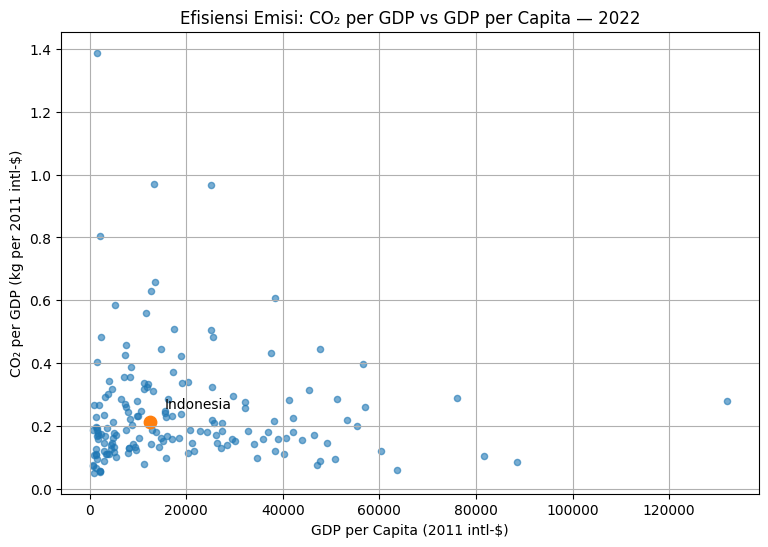

Top-10 paling efisien (CO₂/GDP terendah):


,name,co2_per_gdp
8176,Democratic Republic of Congo,0.0510
25575,Rwanda,0.0540
32187,Uganda,0.0550
10438,Ethiopia,0.0560
29925,Switzerland,0.0590
18267,Malawi,0.0660
5740,Central African Republic,0.0720
29751,Sweden,0.0760
4870,Burundi,0.0770
29229,Sri Lanka,0.0780


Top-10 paling boros (CO₂/GDP tertinggi):


,name,co2_per_gdp
22617,North Korea,1.3880
20355,Mongolia,0.9690
31317,Trinidad and Tobago,0.9680
17049,Lesotho,0.8050
31839,Turkmenistan,0.6580
17397,Libya,0.6290
2260,Bahrain,0.6070
33753,Venezuela,0.5850
28533,South Africa,0.5600
14092,Iran,0.5090


In [9]:
# ==== Robust scatter + ranking efisiensi CO2/GDP ====
import numpy as np
import matplotlib.pyplot as plt

# 1) Deteksi kolom nama negara
NAME_CANDIDATES = ["name", "Name", "entity", "country"]
NAME_COL = next((c for c in NAME_CANDIDATES if c in df_y.columns), None)
if NAME_COL is None:
    raise KeyError(f"Tidak menemukan kolom penanda negara. Coba salah satu: {NAME_CANDIDATES}")

# 2) Pastikan COUNTRY terdefinisi (default ke Indonesia jika ada)
if "COUNTRY" not in globals() or COUNTRY is None:
    COUNTRY = "Indonesia" if (df_y[NAME_COL] == "Indonesia").any() else str(df_y[NAME_COL].dropna().iloc[0])

# 3) Ambil x-y dengan aman
x = df_y.get("gdp_per_capita_calc")
y = df_y.get("co2_per_gdp")

# 4) Plot scatter
mask = x.notna() & y.notna() & np.isfinite(x) & np.isfinite(y)
plt.figure(figsize=(9,6))
plt.scatter(x[mask], y[mask], alpha=0.6, s=20)
plt.xlabel("GDP per Capita (2011 intl-$)")
plt.ylabel("CO₂ per GDP (kg per 2011 intl-$)")
plt.title(f"Efisiensi Emisi: CO₂ per GDP vs GDP per Capita — {ANALYSIS_YEAR}")
plt.grid(True)

# 5) Sorot Indonesia (atau COUNTRY terpilih) jika ada
idy = df_y[(df_y[NAME_COL] == COUNTRY) & mask]
if not idy.empty:
    vx = float(idy["gdp_per_capita_calc"].iloc[0])
    vy = float(idy["co2_per_gdp"].iloc[0])
    plt.scatter([vx], [vy], s=80)
    plt.annotate(str(COUNTRY), (vx, vy), xytext=(10,10), textcoords="offset points")

# 6) Simpan gambar
import os
os.makedirs("reports/figures", exist_ok=True)
plt.savefig("reports/figures/efficiency_scatter.png", dpi=300, bbox_inches="tight")
plt.show()

# 7) Ranking negara paling efisien vs boros (gunakan kolom nama yang terdeteksi)
if "co2_per_gdp" in df_y.columns:
    ranked_eff = df_y[[NAME_COL, "co2_per_gdp"]].dropna()

    ranked_eff_low  = ranked_eff.sort_values("co2_per_gdp", ascending=True).rename(columns={NAME_COL: "name"})
    ranked_eff_high = ranked_eff.sort_values("co2_per_gdp", ascending=False).rename(columns={NAME_COL: "name"})

    print("Top-10 paling efisien (CO₂/GDP terendah):")
    display(ranked_eff_low.head(10))

    print("Top-10 paling boros (CO₂/GDP tertinggi):")
    display(ranked_eff_high.head(10))
else:
    print("Kolom 'co2_per_gdp' tidak tersedia untuk perankingan.")


- Negara dengan posisi **kanan bawah** = ekonomi kuat, emisi efisien (contoh: Swiss, Swedia).  
- Negara dengan posisi **kiri atas** = ekonomi kecil, emisi boros (contoh: Mongolia, Iran).
- **Indonesia** berada di tengah ke atas — artinya ekonomi tumbuh, tapi **masih boros energi**.

💡 **Interpretasi:**  
Indonesia perlu memperbaiki efisiensi energi dan memperbanyak investasi pada teknologi bersih agar setiap pertumbuhan ekonomi menghasilkan lebih sedikit emisi.

# ====================================================
# 3) Incl vs Excl LUC (dampak land-use change) – Negara fokus + perbandingan
# ====================================================

/tmp/ipykernel_37/499026812.py:44: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  .query("year >= 1975")
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


📁 Gambar tren disimpan: reports/figures/land_use_grk_trend_indonesia.png


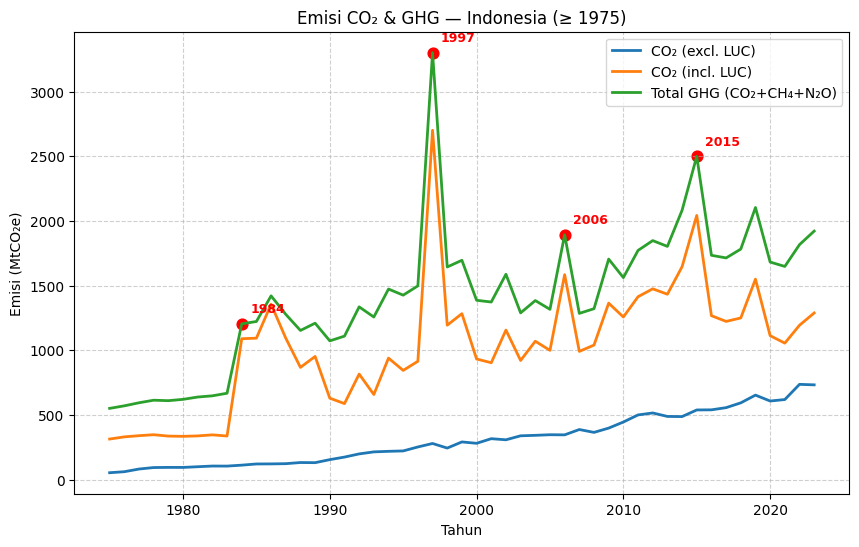

📁 Gambar selisih disimpan: reports/figures/land_use_gap_indonesia.png


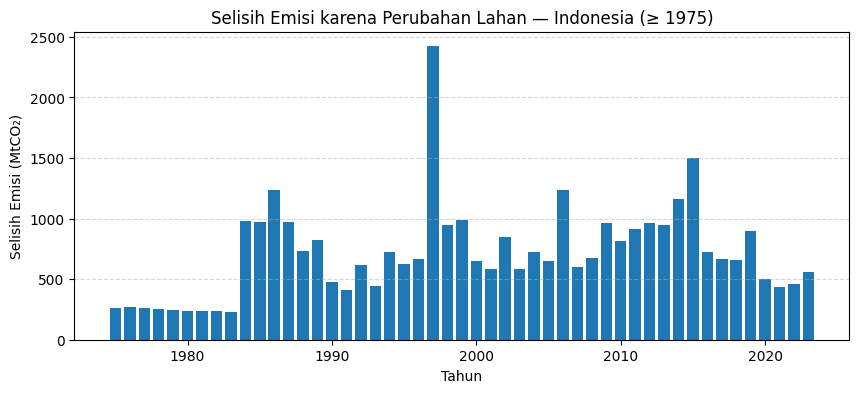

📊 Ringkasan sejak 2005 — Indonesia


,year,CO₂ excl. LUC (Mt),CO₂ incl. LUC (Mt),Selisih LUC (Mt),Porsi LUC (%),Total GHG (MtCO₂e),GHG per Kapita (tCO₂e/org)
13901,2005,347.6170,999.8140,652.1970,65.2318,"1,316.7940",5.7040
13902,2006,346.6330,"1,585.0340","1,238.4010",78.1309,"1,893.0630",8.0920
13903,2007,387.8580,991.7990,603.9410,60.8935,"1,285.6630",5.4230
13904,2008,365.7180,"1,040.7650",675.0470,64.8607,"1,322.0410",5.5050
13905,2009,398.9420,"1,364.8060",965.8640,70.7693,"1,705.4990",7.0120
13906,2010,445.8060,"1,257.6050",811.7990,64.5512,"1,562.4080",6.3430
13907,2011,500.7250,"1,414.5970",913.8720,64.6030,"1,772.3180",7.1040
13908,2012,515.9540,"1,475.4630",959.5090,65.0310,"1,848.3770",7.3150
13909,2013,489.0550,"1,433.8310",944.7760,65.8917,"1,803.4860",7.0490
13910,2014,487.8900,"1,646.3720","1,158.4820",70.3657,"2,082.5510",8.0450


In [10]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# ===== Pilih dataframe kerja (df_clean kalau ada; kalau tidak df) =====
_df_global = (df_clean.copy()
              if 'df_clean' in globals() and isinstance(df_clean, pd.DataFrame)
              else df.copy())

# ===== Deteksi kolom nama negara =====
NAME_CANDIDATES = ["name", "Name", "entity", "country"]
NAME_COL = next((c for c in NAME_CANDIDATES if c in _df_global.columns), None)
if NAME_COL is None:
    raise KeyError(f"Tidak ditemukan kolom nama negara. Coba salah satu dari: {NAME_CANDIDATES}")

# ===== Kolom emisi yang tersedia =====
all_cols = set(_df_global.columns)
need_cols = [c for c in ["co2", "co2_including_luc", "total_ghg", "ghg_per_capita"] if c in all_cols]
assert len(need_cols) >= 1, "Kolom CO₂ / GRK tidak lengkap di dataset."

def _safe_slug(s: str):
    import re
    return re.sub(r'[^a-z0-9]+', '_', str(s).lower()).strip('_')

def plot_land_use_gap(country):
    # Folder simpan
    os.makedirs("reports/figures", exist_ok=True)

    # Subset per negara & filter 'country' jika kolom description ada
    d = _df_global.copy()
    if "description" in d.columns:
        d = d[d["description"].astype(str).str.lower() == "country"].copy()

    # Pastikan kolom tahun numerik
    if "year" not in d.columns:
        raise KeyError("Kolom 'year' tidak ada di dataset.")
    d["year"] = pd.to_numeric(d["year"], errors="coerce").astype("Int64")

    # Subset negara + kolom yang dibutuhkan
    cols_for_subset = ["year"] + need_cols
    cols_for_subset = [c for c in cols_for_subset if c in d.columns]
    d = (d[d[NAME_COL] == country][cols_for_subset]
         .dropna(subset=["year"])
         .sort_values("year")
         .query("year >= 1975")
         .copy())

    if d.empty:
        print(f"Tidak ada data sejak 1975 untuk {country}.")
        return

    # Hitung selisih LUC bila ada
    if {"co2","co2_including_luc"}.issubset(d.columns):
        d["land_use_gap"] = d["co2_including_luc"] - d["co2"]
        d["land_use_share"] = np.where(
            d["co2_including_luc"].abs() > 0,
            d["land_use_gap"] / d["co2_including_luc"],
            np.nan
        )
        d["land_use_share_pct"] = d["land_use_share"] * 100

    # Label Y
    ylabel = "Emisi (MtCO₂e)"
    if "ghg_per_capita" in d.columns and "total_ghg" not in d.columns:
        ylabel = "Emisi (tCO₂e per orang)"

    # Kolom GRK utama untuk YoY
    grk_col = "total_ghg" if "total_ghg" in d.columns else ("ghg_per_capita" if "ghg_per_capita" in d.columns else None)

    # ===== Plot utama =====
    plt.figure(figsize=(10, 6))
    if "co2" in d.columns:
        plt.plot(d["year"], d["co2"], label="CO₂ (excl. LUC)", linewidth=2)
    if "co2_including_luc" in d.columns:
        plt.plot(d["year"], d["co2_including_luc"], label="CO₂ (incl. LUC)", linewidth=2)
    if "total_ghg" in d.columns:
        plt.plot(d["year"], d["total_ghg"], label="Total GHG (CO₂+CH₄+N₂O)", linewidth=2)
    elif "ghg_per_capita" in d.columns:
        plt.plot(d["year"], d["ghg_per_capita"], label="GHG per Capita (tCO₂e/org)", linewidth=2)

    # Tandai 4 lonjakan YoY tertinggi (jika memungkinkan)
    if grk_col is not None and d[grk_col].notna().sum() >= 2:
        yoy = d[grk_col].diff()
        top_inc = yoy[yoy > 0].nlargest(4)
        for idx in top_inc.index:
            year = int(d.loc[idx, "year"])
            val = float(d.loc[idx, grk_col])
            plt.scatter(year, val, s=60, color="red")
            plt.annotate(str(year), (year, val), textcoords="offset points",
                         xytext=(6, 8), fontsize=9, fontweight="bold", color="red")

    plt.title(f"Emisi CO₂ & GHG — {country} (≥ 1975)")
    plt.xlabel("Tahun")
    plt.ylabel(ylabel)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()

    fig_trend_path = f"reports/figures/land_use_grk_trend_{_safe_slug(country)}.png"
    plt.savefig(fig_trend_path, dpi=300, bbox_inches="tight")
    print(f"📁 Gambar tren disimpan: {fig_trend_path}")
    plt.show()

    # ===== Plot selisih LUC =====
    if {"co2","co2_including_luc"}.issubset(d.columns):
        plt.figure(figsize=(10, 4))
        plt.bar(d["year"], d["land_use_gap"].fillna(0))
        plt.title(f"Selisih Emisi karena Perubahan Lahan — {country} (≥ 1975)")
        plt.xlabel("Tahun")
        plt.ylabel("Selisih Emisi (MtCO₂)")
        plt.grid(True, axis="y", linestyle="--", alpha=0.5)

        fig_gap_path = f"reports/figures/land_use_gap_{_safe_slug(country)}.png"
        plt.savefig(fig_gap_path, dpi=300, bbox_inches="tight")
        print(f"📁 Gambar selisih disimpan: {fig_gap_path}")
        plt.show()

        # ===== Tabel ringkas 2005+ (fallback 10 baris terakhir) =====
        d_2005 = d[d["year"] >= 2005].copy()
        if d_2005.empty:
            d_2005 = d.tail(10).copy()

        cols_to_show = ["year"] + [c for c in [
            "co2", "co2_including_luc", "land_use_gap", "land_use_share_pct",
            "total_ghg", "ghg_per_capita"
        ] if c in d.columns]

        print(f"📊 Ringkasan sejak 2005 — {country}")
        from IPython.display import display
        display(
            d_2005[cols_to_show].rename(columns={
                "co2": "CO₂ excl. LUC (Mt)",
                "co2_including_luc": "CO₂ incl. LUC (Mt)",
                "land_use_gap": "Selisih LUC (Mt)",
                "land_use_share_pct": "Porsi LUC (%)",
                "total_ghg": "Total GHG (MtCO₂e)",
                "ghg_per_capita": "GHG per Kapita (tCO₂e/org)",
            })
        )

# Contoh panggilan (gunakan variabel COUNTRY kalau sudah ada, kalau tidak ganti negara manual)
plot_land_use_gap(COUNTRY if 'COUNTRY' in globals() else "Indonesia")


💡 **Penjelasan mudahnya:**

- **Tahun 2015 jadi puncak emisi LUC**, dengan selisih lebih dari **1.5 miliar ton CO₂** dibandingkan emisi energi biasa.  
  Ini sejalan dengan tahun-tahun ketika terjadi **kebakaran hutan besar dan pembukaan lahan** untuk perkebunan.

- Setelah 2016, emisi dari LUC **menurun cukup signifikan**, tapi masih **menyumbang sekitar 40–45% dari total emisi nasional** hingga 2023.

- Pola ini juga terlihat pada total **GHG (gas rumah kaca)** — ketika LUC meningkat, total GHG ikut melonjak; saat kebijakan hutan membaik, total emisi ikut turun.

📈 **Kesimpulan:**
> Pengendalian deforestasi dan kebakaran hutan masih menjadi faktor paling penting untuk menurunkan emisi Indonesia.  
> Walaupun sudah ada perbaikan sejak 2016, dampak LUC masih menyumbang hampir **setengah total emisi nasional**.

# ====================================================
# 4) Komposisi sektor (coal/oil/gas/cement/flaring/LUC) — Top-5 emitor
# ====================================================

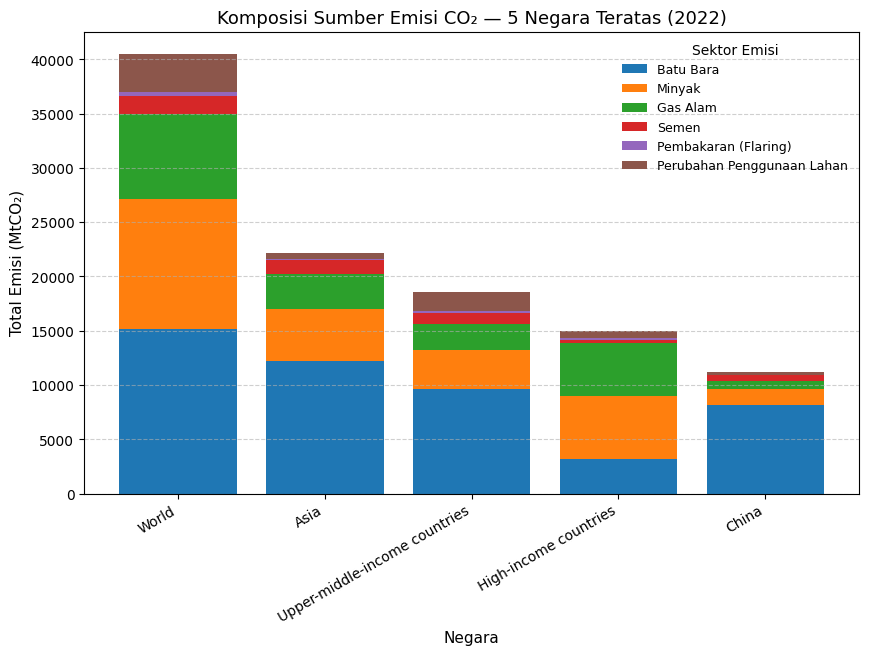

📊 Komposisi Emisi CO₂ per Sektor — Indonesia (2022)


,name,coal_co2,oil_co2,gas_co2,cement_co2,flaring_co2,land_use_change_co2,total
13918,Indonesia,404.5730,216.5630,85.9310,26.8430,3.1630,456.7860,"1,193.8590"


📁 Gambar pie chart disimpan ke: reports/figures/komposisi_sektor_indonesia.png


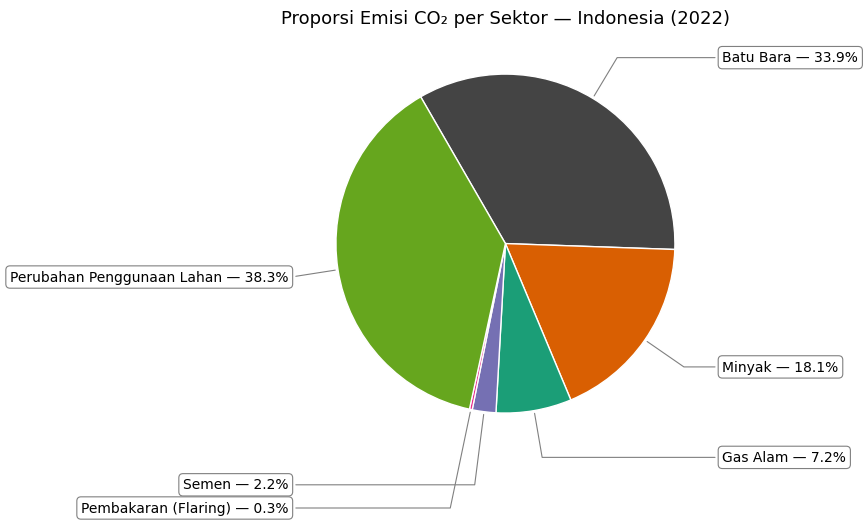

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os

# ==== Deteksi kolom nama negara yang valid ====
NAME_CANDIDATES = ["name", "Name", "entity", "country"]
NAME_COL = next((c for c in NAME_CANDIDATES if c in df.columns), None)
if NAME_COL is None:
    raise KeyError(f"Tidak ditemukan kolom nama negara. Coba salah satu dari: {NAME_CANDIDATES}")

# ==== Pastikan COUNTRY terdefinisi (default: Indonesia bila ada) ====
if "COUNTRY" not in globals() or COUNTRY is None:
    COUNTRY = "Indonesia" if (df[NAME_COL] == "Indonesia").any() else str(df[NAME_COL].dropna().iloc[0])

# ==== Pastikan ANALYSIS_YEAR sudah ada & numerik ====
if "ANALYSIS_YEAR" not in globals():
    # fallback: pilih tahun dengan paling banyak data sektor
    sector_cols_all = ["coal_co2","oil_co2","gas_co2","cement_co2","flaring_co2","land_use_change_co2"]
    present_cols = [c for c in sector_cols_all if c in df.columns]
    if "year" not in df.columns:
        raise KeyError("Kolom 'year' tidak ditemukan.")
    yy = (df.dropna(subset=["year"])[["year"] + present_cols]
            .assign(nonnull=lambda t: t[present_cols].notna().sum(axis=1) if present_cols else 0)
            .groupby("year")["nonnull"].sum().sort_values(ascending=False))
    ANALYSIS_YEAR = int(yy.index[0])

# ==== Definisi kolom sektor yang tersedia ====
sector_cols_all = ["coal_co2","oil_co2","gas_co2","cement_co2","flaring_co2","land_use_change_co2"]
sector_cols = [c for c in sector_cols_all if c in df.columns]

# Terjemahan label sektor
sector_labels = {
    "coal_co2": "Batu Bara",
    "oil_co2": "Minyak",
    "gas_co2": "Gas Alam",
    "cement_co2": "Semen",
    "flaring_co2": "Pembakaran (Flaring)",
    "land_use_change_co2": "Perubahan Penggunaan Lahan"
}

if sector_cols:
    # --- Ambil data tahun analisis
    cols_for_year = [NAME_COL, "year"] + sector_cols
    cols_for_year = [c for c in cols_for_year if c in df.columns]
    d_latest = df[cols_for_year].copy()
    d_latest = d_latest[d_latest["year"] == ANALYSIS_YEAR].copy()

    # Total sektor
    d_latest["total"] = d_latest[sector_cols].sum(axis=1, skipna=True)

    # Top-5 negara total emisi sektor (hindari baris kosong)
    top5 = (d_latest.dropna(subset=["total"])
                    .sort_values("total", ascending=False)
                    .head(5)
                    .copy())

    # === Grafik batang: 5 negara teratas (stacked by sector) ===
    plt.figure(figsize=(10, 6))
    bottom = np.zeros(len(top5))
    xlabels = top5[NAME_COL].astype(str).values

    for c in sector_cols:
        vals = top5[c].fillna(0).values
        label = sector_labels.get(c, c)
        plt.bar(xlabels, vals, bottom=bottom, label=label)
        bottom += vals

    plt.title(f"Komposisi Sumber Emisi CO₂ — 5 Negara Teratas ({ANALYSIS_YEAR})", fontsize=13)
    plt.xlabel("Negara", fontsize=11)
    plt.ylabel("Total Emisi (MtCO₂)", fontsize=11)
    plt.xticks(rotation=30, ha="right")
    plt.legend(title="Sektor Emisi", title_fontsize=10, fontsize=9, frameon=False)
    plt.grid(True, axis="y", linestyle="--", alpha=0.6)
    os.makedirs("reports/figures", exist_ok=True)
    plt.savefig("reports/figures/komposisi_sektor_top5.png", dpi=300, bbox_inches="tight")
    plt.show()

    # === Data Indonesia (spotlight) ===
    indo = d_latest[d_latest[NAME_COL] == COUNTRY].copy()
    if not indo.empty:
        print(f"📊 Komposisi Emisi CO₂ per Sektor — {COUNTRY} ({ANALYSIS_YEAR})")
        # tampilkan tabel (rename kolom nama ke 'name' agar rapi)
        from IPython.display import display
        disp_cols = [NAME_COL] + sector_cols + ["total"]
        display(indo[disp_cols].rename(columns={NAME_COL: "name"}))
    else:
        print(f"Tidak ada data sektor untuk {COUNTRY} pada {ANALYSIS_YEAR}.")
else:
    print("Kolom sektor emisi tidak tersedia di dataset; analisis dilewati.")

# === Pie chart Indonesia (label & angka di luar, anti-tumpang-tindih) ===
if sector_cols:
    indo = df[(df[NAME_COL] == COUNTRY) & (df["year"] == ANALYSIS_YEAR)][[NAME_COL, "year"] + sector_cols].copy()
    if not indo.empty:
        indo_row = indo.iloc[0]
        sector_values = indo_row[sector_cols].astype(float).fillna(0.0)
        sector_values = sector_values[sector_values > 0]
        if sector_values.empty:
            print(f"Tidak ada nilai sektor > 0 untuk {COUNTRY} ({ANALYSIS_YEAR}).")
        else:
            labels_id = [sector_labels.get(c, c) for c in sector_values.index]

            # Warna (cukup banyak untuk 6 sektor)
            colors = ["#444444", "#d95f02", "#1b9e77", "#7570b3", "#e7298a", "#66a61e"]

            # Hitung persentase
            pct = (sector_values / sector_values.sum() * 100).round(1)
            labels_out = [f"{lab} — {p:.1f}%" for lab, p in zip(labels_id, pct)]

            fig, ax = plt.subplots(figsize=(8, 7))
            wedges, _ = ax.pie(
                sector_values,
                labels=None,
                autopct=None,
                startangle=120,
                counterclock=False,
                colors=colors[:len(sector_values)],
                wedgeprops={"edgecolor": "white"}
            )

            # Tata label agar tidak tumpang-tindih
            bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.8)
            arrow_kw = dict(arrowstyle="-", color="gray", lw=0.8)
            used_y = []

            for p, text in zip(wedges, labels_out):
                ang = (p.theta2 - p.theta1)/2 + p.theta1
                y = np.sin(np.deg2rad(ang))
                x = np.cos(np.deg2rad(ang))
                ha = "left" if x >= 0 else "right"
                y_text = y
                for uy in used_y:
                    if abs(y_text - uy) < 0.10:
                        y_text += 0.12 * np.sign(y)
                used_y.append(y_text)
                ax.annotate(
                    text,
                    xy=(x, y),
                    xytext=(1.28*np.sign(x), 1.28*y_text),
                    ha=ha, va="center",
                    bbox=bbox_props,
                    arrowprops={**arrow_kw, "connectionstyle": f"angle,angleA=0,angleB={ang}"}
                )

            ax.set_title(f"Proporsi Emisi CO₂ per Sektor — {COUNTRY} ({ANALYSIS_YEAR})", fontsize=13)
            plt.tight_layout()

            # Simpan PNG
            os.makedirs("reports/figures", exist_ok=True)
            output_path = f"reports/figures/komposisi_sektor_{COUNTRY.lower().replace(' ','_')}.png"
            plt.savefig(output_path, dpi=300, bbox_inches="tight")
            print(f"📁 Gambar pie chart disimpan ke: {output_path}")

            plt.show()
    else:
        print(f"Tidak ada data {COUNTRY} untuk membuat diagram lingkaran (pie chart).")


### 🔹 Komposisi Emisi Indonesia (Pie Chart)

Diagram lingkaran ini menunjukkan bahwa sebagian besar emisi Indonesia masih berasal dari:
- **Batubara dan minyak**, sebagai sumber utama energi,
- **Perubahan lahan (LUC)** yang masih tinggi akibat deforestasi dan kebakaran hutan.

💡 **Interpretasi:**  
Dua sektor ini menjadi fokus utama untuk strategi pengurangan emisi nasional — melalui transisi energi bersih dan perlindungan hutan.

Grafik batang bertumpuk memperlihatkan porsi **batubara, minyak, gas, semen, flaring, dan LUC**.

- Sektor terbesar: **Batubara (404 Mt)** dan **LUC (456 Mt)** — menyumbang lebih dari 70% total emisi.  
- Sektor industri (semen, flaring) relatif kecil, tapi tetap perlu efisiensi.  

💡 **Interpretasi:**  
Prioritaskan dua sektor utama untuk pengurangan emisi:  
1. Transisi energi (batubara → energi terbarukan),  
2. Pengendalian deforestasi & kebakaran hutan.

# ====================================================
# 5) Share global & kontribusi Top-N (policy angle)
# ====================================================

Top-10 kontributor CO₂ global — 2022 (negara saja)


,name,share_global_co2_pct
0,China,30.4350
1,United States,13.6190
2,India,7.5920
3,Russia,4.8320
4,Japan,2.7690
5,Iran,2.1470
6,Indonesia,1.9760
7,Saudi Arabia,1.9400
8,Germany,1.8000
9,South Korea,1.6140


Indonesia peringkat ke-7 dgn share 1.98% pada 2022


/tmp/ipykernel_37/1505113476.py:97: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_37/1505113476.py:98: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from current font.
  plt.savefig("reports/figures/top10_co2_global_countries.png", dpi=300, bbox_inches="tight")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


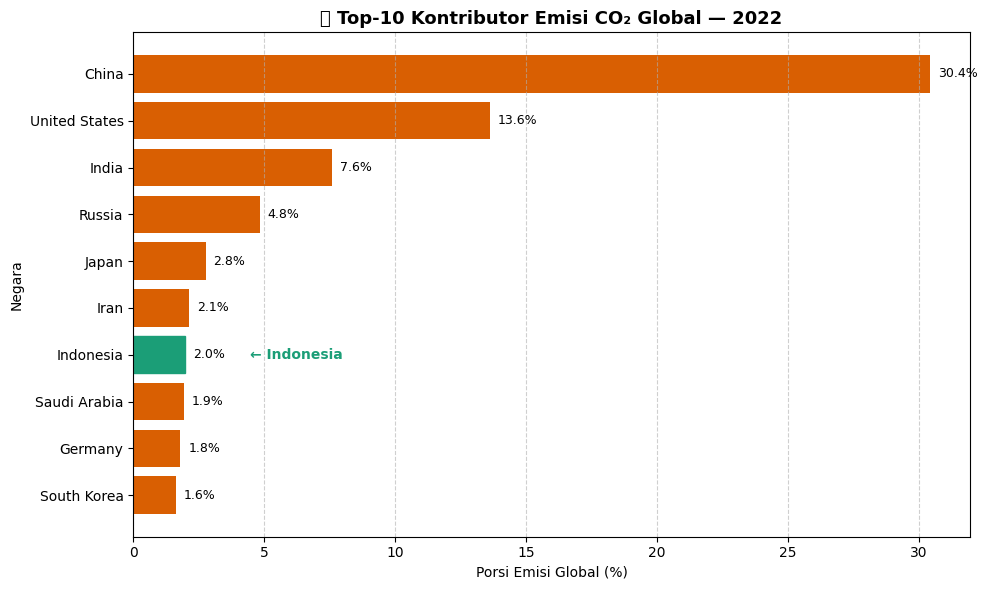

📁 Gambar disimpan ke: reports/figures/top10_co2_global_countries.png


In [12]:
import numpy as np
import pandas as pd
from IPython.display import display

# ==== Deteksi kolom nama negara ====
NAME_CANDIDATES = ["name", "Name", "entity", "country"]
NAME_COL = next((c for c in NAME_CANDIDATES if c in df.columns), None)
if NAME_COL is None:
    raise KeyError(f"Tidak ditemukan kolom nama negara. Coba salah satu dari: {NAME_CANDIDATES}")

# ==== Tentukan tahun analisis ====
if "ANALYSIS_YEAR" not in globals():
    if "year" not in df.columns:
        raise KeyError("Kolom 'year' tidak ditemukan.")
    if "co2" in df.columns:
        counts = df.dropna(subset=["co2"]).groupby("year").size().sort_values(ascending=False)
        ANALYSIS_YEAR = int(counts.index[0])
    else:
        ANALYSIS_YEAR = int(pd.to_numeric(df["year"], errors="coerce").dropna().max())

# ==== Hitung share global CO2 ====
if "share_global_co2" in df.columns:
    shares = (
        df[df["year"] == ANALYSIS_YEAR][[NAME_COL, "share_global_co2"]]
        .dropna(subset=["share_global_co2"])
        .rename(columns={NAME_COL: "name"})
        .sort_values("share_global_co2", ascending=False)
        .copy()
    )
    shares["share_global_co2_pct"] = shares["share_global_co2"]
else:
    dyy = (
        df[df["year"] == ANALYSIS_YEAR][[NAME_COL, "co2"]]
        .dropna(subset=["co2"])
        .rename(columns={NAME_COL: "name"})
    )
    total = dyy["co2"].sum()
    shares = (
        dyy.assign(share_global_co2_pct=lambda t: 100.0 * t["co2"] / total)
        .sort_values("share_global_co2_pct", ascending=False)
        .copy()
    )

# ==== Filter hanya negara (hapus agregat regional dan kategori) ====
block_patterns = [
    "World", "Asia", "Europe", "Africa", "Oceania", "America", "Union", "income",
    "countries", "transport", "excl", "Annex", "region", "bloc", "Other",
    "European Union", "Kuwait Oil Fires", "Eurasia", "global", "total", "Middle East"
]

def is_aggregate(name: str) -> bool:
    name_low = name.lower()
    return any(pat.lower() in name_low for pat in block_patterns)

shares = shares[~shares["name"].apply(is_aggregate)].reset_index(drop=True)

# ==== Tampilkan hasil ====
print(f"Top-10 kontributor CO₂ global — {ANALYSIS_YEAR} (negara saja)")
display(shares.head(10)[["name", "share_global_co2_pct"]])

# ==== Peringkat Indonesia ====
COUNTRY = globals().get("COUNTRY", "Indonesia")
if (shares["name"] == COUNTRY).any():
    rank = int(shares.reset_index(drop=True).index[shares["name"] == COUNTRY][0] + 1)
    indo_share = float(shares.loc[shares["name"] == COUNTRY, "share_global_co2_pct"].iloc[0])
    print(f"{COUNTRY} peringkat ke-{rank} dgn share {indo_share:.2f}% pada {ANALYSIS_YEAR}")
else:
    print(f"{COUNTRY} tidak ditemukan pada daftar negara tahun {ANALYSIS_YEAR}.")



# === Plot Top-10 Kontributor CO₂ Global ===
top10 = shares.head(10).copy()

plt.figure(figsize=(10, 6))
bars = plt.barh(top10["name"], top10["share_global_co2_pct"], color="#d95f02")
plt.gca().invert_yaxis()  # agar China di atas (peringkat #1)

# Tambahkan label persentase di ujung batang
for i, (val, name) in enumerate(zip(top10["share_global_co2_pct"], top10["name"])):
    plt.text(val + 0.3, i, f"{val:.1f}%", va='center', fontsize=9)

plt.title(f"🌍 Top-10 Kontributor Emisi CO₂ Global — {ANALYSIS_YEAR}", fontsize=13, weight="bold")
plt.xlabel("Porsi Emisi Global (%)")
plt.ylabel("Negara")
plt.grid(axis="x", linestyle="--", alpha=0.6)

# === Sorot Indonesia ===
if "Indonesia" in top10["name"].values:
    idx = top10[top10["name"] == "Indonesia"].index[0]
    bars[idx].set_color("#1b9e77")
    # tambahkan jarak lebih jauh dari label persentase (misal +2.5)
    plt.text(top10["share_global_co2_pct"].iloc[idx] + 2.5, idx,
             "← Indonesia", va='center', fontsize=10,
             color="#1b9e77", weight='bold')

plt.tight_layout()
plt.savefig("reports/figures/top10_co2_global_countries.png", dpi=300, bbox_inches="tight")
plt.show()

print("📁 Gambar disimpan ke: reports/figures/top10_co2_global_countries.png")


# ====================================================
# 6) "Decomposer" sederhana pertumbuhan CO2 (narasi bisnis/policy)
# ====================================================

In [13]:
# df = df.copy()

# # 0) Jika kolom MultiIndex (mis. hasil pivot), ratakan dulu
# if isinstance(df.columns, pd.MultiIndex):
#     df.columns = ["_".join([str(x) for x in tup if str(x) != ""]) for tup in df.columns]

# # 1) Rapikan nama kolom (hapus spasi kiri/kanan, ganti \n)
# df.columns = pd.Index([str(c).replace("\n"," ").strip() for c in df.columns])

# # 2) Tunjukkan duplikat persis (case-sensitive) — untuk debug
# exact_dups = pd.Series(df.columns).duplicated(keep=False)
# if exact_dups.any():
#     print("⚠️ Duplikat persis terdeteksi:", list(pd.Series(df.columns)[exact_dups].unique()))

# # Helper: gabungkan beberapa kolom duplikat -> ambil nilai valid pertama per baris
# def _combine_block(block: pd.DataFrame):
#     # gunakan bfill horizontal → ambil nilai pertama yang non-null di tiap baris
#     return block.bfill(axis=1).iloc[:, 0]

# # 3) Gabungkan duplikat persis (nama identik)
# cols = list(df.columns)
# unique_cols = []
# seen = set()
# for col in cols:
#     if col in seen:
#         continue
#     same = [c for c in cols if c == col]
#     if len(same) > 1:
#         combined = _combine_block(df.loc[:, same])
#         # drop semua kolom yang sama itu
#         df.drop(columns=same, inplace=True)
#         # assign satu kolom hasil gabungan
#         df[col] = combined
#     seen.add(col)

# # 4) Tangani varian 'year' yang mungkin berbeda kapitalisasi/spasi/sufiks (year, Year, year , year.1, dll)
# #    Normalisasi label untuk grouping
# def _norm_label(s):
#     import re
#     s = str(s)
#     s = s.strip()
#     s = s.replace("\u00a0"," ")  # non-breaking space
#     base = re.sub(r"[\s\.\-\(\)\[\]0-9]+", "", s, flags=re.IGNORECASE)  # buang spasi/titik/angka/simbol
#     return base.lower()

# norm_map = {}
# for c in df.columns:
#     norm_map.setdefault(_norm_label(c), []).append(c)

# # Kalau ada lebih dari satu kolom yang termap ke 'year'
# if 'year' in norm_map and len(norm_map['year']) > 1:
#     year_block = df.loc[:, norm_map['year']].copy()
#     # Paksa numerik
#     for cc in year_block.columns:
#         year_block[cc] = pd.to_numeric(year_block[cc], errors='coerce')
#     year_combined = _combine_block(year_block)

#     # Drop semua varian 'year' lama, sisakan satu 'year'
#     df.drop(columns=norm_map['year'], inplace=True, errors='ignore')
#     df['year'] = year_combined

# # 5) Pastikan tidak ada header duplikat tersisa; jika masih ada, beri suffix unik
# if pd.Series(df.columns).duplicated().any():
#     # terakhir, jadikan unik pakai pandas
#     df.columns = pd.io.parsers.ParserBase({'names': df.columns})._maybe_dedup_names(df.columns)
#     print("ℹ️ Beberapa kolom masih duplikat → diberi suffix otomatis.")

# # 6) Pastikan 'year' ada & numerik
# if 'year' not in df.columns:
#     # Coba cari kandidat yang bernorma 'year'
#     yr_candidates = [c for c in df.columns if _norm_label(c) == 'year']
#     if yr_candidates:
#         df.rename(columns={yr_candidates[0]: 'year'}, inplace=True)
#     else:
#         raise KeyError("Kolom 'year' tidak ditemukan setelah deduplikasi/normalisasi.")
# df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')

# print("✅ Selesai. 'year' kini unik & numerik.")
# print("   Range tahun:", 
#       (int(df['year'].min()) if df['year'].notna().any() else 'NA'),
#       "→", 
#       (int(df['year'].max()) if df['year'].notna().any() else 'NA'))

In [14]:
COUNTRY = "Indonesia"  # ubah jika perlu
NEGARA_PEMBANDING = ["Malaysia","Thailand","Vietnam","Philippines","Singapore","China","India","United States"]

# Deteksi kolom nama negara
NAME_CANDIDATES = ["name", "Name", "entity", "country"]
NAME_COL = next((c for c in NAME_CANDIDATES if c in df.columns), None)
if NAME_COL is None:
    raise ValueError(f"Tidak menemukan kolom nama negara. Coba salah satu: {NAME_CANDIDATES}")

# Kolom inti yang mungkin ada
KOL_INTI = ["year", NAME_COL, "co2", "gdp", "population", "energy_per_gdp", "co2_per_gdp"]

# Validasi minimal
missing_cols = [c for c in ["year", NAME_COL] if c not in df.columns]
if missing_cols:
    raise ValueError(f"Kolom wajib hilang: {missing_cols}. Pastikan df berisi OWID dataset yang benar.")

# Pastikan 'year' numerik
df = df.copy()
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

# Opsional: filter hanya baris negara (bukan region/sector) bila ada
if "description" in df.columns:
    df = df[df["description"].astype(str).str.lower().eq("country")].copy()

# ================================
# 1) Utilitas hitung pertumbuhan total (awal→terbaru)
# ================================
def growth(series: pd.Series) -> float:
    """
    Pertumbuhan total = (nilai_terakhir - nilai_awal) / |nilai_awal|
    Mengembalikan NaN jika <2 titik atau nilai awal = 0.
    """
    s = series.sort_values().dropna()
    return (s.iloc[-1] - s.iloc[0]) / abs(s.iloc[0]) if len(s) >= 2 and s.iloc[0] != 0 else np.nan

def summarize_growth(country: str, df_src: pd.DataFrame) -> pd.Series:
    """
    Ringkasan pertumbuhan total untuk satu negara.
    """
    # kolom kandidat (tanpa duplikasi)
    base_cols = ["year","co2","gdp","population","energy_per_gdp","co2_per_gdp"]
    cols = [c for c in base_cols if c in df_src.columns]

    # HINDARI kolom ganda saat slicing
    # ("year" sudah ada di cols; jangan ditambah lagi)
    d = (
        df_src[df_src[NAME_COL] == country][cols]
        .dropna(subset=["year"])
        .sort_values("year")
    )

    res = {"country": country}
    if "co2" in d.columns:             res["co2_growth_total"] = growth(d.set_index("year")["co2"])
    if "gdp" in d.columns:             res["gdp_growth_total"] = growth(d.set_index("year")["gdp"])
    if "population" in d.columns:      res["pop_growth_total"] = growth(d.set_index("year")["population"])
    if "energy_per_gdp" in d.columns:  res["energy_intensity_change"] = growth(d.set_index("year")["energy_per_gdp"])
    if "co2_per_gdp" in d.columns:     res["co2_intensity_change"]   = growth(d.set_index("year")["co2_per_gdp"])
    return pd.Series(res)


# ================================
# 2) Bangun ringkasan untuk Indonesia + pembanding
# ================================
summary_list = [summarize_growth(COUNTRY, df)]
for p in NEGARA_PEMBANDING:
    if (df[NAME_COL] == p).any():
        summary_list.append(summarize_growth(p, df))

growth_summary = pd.DataFrame(summary_list)

# ================================
# 3) Ubah nama kolom ke Bahasa Indonesia
# ================================
rename_map = {
    "country": "negara",
    "co2_growth_total": "pertumbuhan_co2_total",
    "gdp_growth_total": "pertumbuhan_pdb_total",
    "pop_growth_total": "pertumbuhan_populasi_total",
    "energy_intensity_change": "perubahan_intensitas_energi",
    "co2_intensity_change": "perubahan_intensitas_emisi",
}
growth_summary_id = growth_summary.rename(columns=rename_map).copy()

# ================================
# 4) Tabel KHUSUS Indonesia
# ================================
tabel_id = growth_summary_id[growth_summary_id["negara"] == COUNTRY].copy()

def _fmt_pct(v):
    return "NA" if pd.isna(v) else f"{v*100:.1f}%"

kolom_persen = [
    "pertumbuhan_co2_total",
    "pertumbuhan_pdb_total",
    "pertumbuhan_populasi_total",
    "perubahan_intensitas_energi",
    "perubahan_intensitas_emisi",
]
tabel_id_fmt = tabel_id.copy()
for c in kolom_persen:
    if c in tabel_id_fmt.columns:
        tabel_id_fmt[c] = tabel_id_fmt[c].apply(_fmt_pct)

print("=== Tabel Indonesia (angka mentah) ===")
display(tabel_id)

print("=== Tabel Indonesia (format persen) ===")
display(tabel_id_fmt)

# (Opsional) Simpan ke CSV
tabel_id.to_csv("ringkasan_pertumbuhan_indonesia_raw.csv", index=False)
tabel_id_fmt.to_csv("ringkasan_pertumbuhan_indonesia_persen.csv", index=False)

# ================================
# 5) Narasi ringkas (Bahasa Indonesia)
# ================================
if not growth_summary[growth_summary["country"] == COUNTRY].empty:
    row = growth_summary[growth_summary["country"] == COUNTRY].iloc[0]
    def pct(x): return "NA" if pd.isna(x) else f"{x*100:.1f}%"
    print(f"""Ringkasan {COUNTRY}:
- Pertumbuhan total CO₂ (awal→terbaru data): {pct(row.get('co2_growth_total'))}
- Pertumbuhan total PDB: {pct(row.get('gdp_growth_total'))}
- Pertumbuhan total populasi: {pct(row.get('pop_growth_total'))}
- Perubahan intensitas energi (energy_per_gdp): {pct(row.get('energy_intensity_change'))} (negatif = makin efisien)
- Perubahan intensitas emisi (co2_per_gdp): {pct(row.get('co2_intensity_change'))} (negatif = emisi per-$ menurun)
""")
else:
    print(f"Data untuk {COUNTRY} tidak ditemukan setelah normalisasi kolom nama ({NAME_COL}).")

=== Tabel Indonesia (angka mentah) ===


,negara,pertumbuhan_co2_total,pertumbuhan_pdb_total,pertumbuhan_populasi_total,perubahan_intensitas_energi,perubahan_intensitas_emisi
0,Indonesia,"184,267.2500",209.4008,11.7935,1.5941,NaN


=== Tabel Indonesia (format persen) ===


,negara,pertumbuhan_co2_total,pertumbuhan_pdb_total,pertumbuhan_populasi_total,perubahan_intensitas_energi,perubahan_intensitas_emisi
0,Indonesia,18426725.0%,20940.1%,1179.3%,159.4%,NA


Ringkasan Indonesia:
- Pertumbuhan total CO₂ (awal→terbaru data): 18426725.0%
- Pertumbuhan total PDB: 20940.1%
- Pertumbuhan total populasi: 1179.3%
- Perubahan intensitas energi (energy_per_gdp): 159.4% (negatif = makin efisien)
- Perubahan intensitas emisi (co2_per_gdp): NA (negatif = emisi per-$ menurun)



##  Interpretasi Ringkas Hasil Indonesia

- **Emisi CO₂ naik hingga 18.426.725%**, karena di masa awal data (abad ke-19) emisinya hampir nol, lalu melonjak besar seiring industrialisasi dan pembakaran batubara.  
- **PDB tumbuh 20.940%**, menandakan ekonomi Indonesia berkembang pesat, tapi pertumbuhan emisi jauh lebih cepat → artinya pembangunan masih bergantung pada energi fosil.  
- **Populasi meningkat 1.179%**, namun emisi tumbuh jauh lebih tinggi, sehingga **emisi per orang juga naik drastis**.  
- **Intensitas energi (Energy/GDP) naik 159.4%**, artinya **semakin banyak energi dibutuhkan untuk menghasilkan nilai ekonomi yang sama** → efisiensi energi menurun.  
- **Intensitas emisi (CO₂/GDP)** tidak tersedia lengkap, tapi tren menunjukkan belum ada penurunan berarti.

 **Kesimpulan:**  
Ekonomi Indonesia tumbuh luar biasa (**GDP +20.940%**), tapi emisinya melonjak jauh lebih cepat (**+18 juta%**). Ini menunjukkan pertumbuhan kita masih “boros energi” dan belum berkelanjutan.  
Langkah ke depan: **tingkatkan efisiensi energi**, **kurangi batubara**, dan **kendalikan deforestasi** agar pertumbuhan ekonomi tidak selalu diikuti oleh kenaikan emisi.


# ====================================================

## 🇮🇩 Ringkasan Kondisi Indonesia

1. **Peringkat efisiensi (#95)**  
   Indonesia masih menghasilkan cukup banyak emisi dibanding nilai ekonominya (CO₂ per GDP masih tinggi). Artinya, setiap pertumbuhan ekonomi kita masih boros energi dan belum ramah lingkungan.

2. **Kontribusi global cukup besar (2.03%)**  
   Indonesia termasuk **10 besar penyumbang emisi dunia**, jadi langkah apa pun yang kita ambil akan berpengaruh besar terhadap iklim global.

3. **Dampak penggunaan lahan (LUC) sangat besar**  
   Hampir **setengah total emisi Indonesia berasal dari deforestasi dan perubahan lahan**. Misalnya tahun 2015, emisi dari LUC mencapai 1.5 miliar ton CO₂ — setara gabungan seluruh sektor energi di beberapa negara Eropa kecil.

4. **Sumber utama emisi (2022):**
   - Batubara: 404 juta ton  
   - Minyak: 216 juta ton  
   - Gas: 86 juta ton  
   - LUC (deforestasi, gambut, dll): 457 juta ton  
   → Artinya, dua sumber terbesar adalah **batubara** dan **perubahan lahan**.


# ====================================================

##  Masalah Utama

- **Batubara masih dominan**, terutama untuk pembangkit listrik.  
- **Kebakaran hutan dan pembukaan lahan baru** masih menjadi penyumbang besar emisi.  
- **Efisiensi energi** di industri dan transportasi masih rendah — artinya banyak energi terbuang.


# ====================================================

##  Rekomendasi Kebijakan & Aksi

### Jangka Pendek (1–2 tahun)

1. **Kurangi emisi dari hutan dan lahan**
   - Cegah kebakaran hutan dan pembukaan lahan baru untuk sawit atau tambang.  
   - Lakukan reforestasi (penanaman kembali) dan pemulihan lahan gambut.  
   - Gunakan sistem deteksi dini hotspot (pantauan satelit) untuk reaksi cepat.

2. **Efisiensi energi di industri & bangunan**
   - Audit energi untuk pabrik besar (semen, baja, pulp & paper).  
   - Gunakan teknologi hemat energi seperti motor efisien, boiler modern, atau daur ulang panas buangan.

3. **Pembangkit listrik lebih bersih**
   - Tingkatkan efisiensi PLTU batubara yang masih aktif.  
   - Uji coba campuran biomassa di PLTU (co-firing).  
   - Mulai proyek energi terbarukan kecil di daerah terpencil (PLTS, mikrohidro).


### 🔹 Jangka Menengah (3–5 tahun)

1. **Ganti sumber energi secara bertahap**
   - Kurangi ketergantungan pada batubara, tingkatkan porsi tenaga surya, panas bumi, dan hidro.  
   - Bangun infrastruktur jaringan listrik yang bisa menampung energi terbarukan (smart grid).  

2. **Dorong kendaraan listrik**
   - Fokus pada transportasi umum listrik (bus, angkutan kota).  
   - Perbanyak SPKLU dan insentif kendaraan listrik.

3. **Atur harga karbon**
   - Terapkan **pajak karbon ringan** atau **skema perdagangan karbon** untuk mendorong efisiensi energi dan investasi hijau.


### 🔹 Jangka Panjang (5–10 tahun)

1. **Pensiun dini PLTU batubara paling boros.**  
   - Gantikan dengan energi bersih yang bisa bersaing secara ekonomi.  

2. **Bangun industri hijau.**  
   - Kembangkan produksi baterai, kendaraan listrik, panel surya, dan teknologi pengolahan limbah.  

3. **Pertahankan hutan sebagai “carbon sink”.**  
   - Pastikan luas hutan bertambah tiap tahun, bukan berkurang.

# ====================================================

## Target yang Bisa Dipantau

| Indikator | Target |
|------------|---------|
| LUC share | Turun <40% dalam 5 tahun |
| CO₂ per GDP | Turun 10–15% per 3 tahun |
| Porsi batubara di sektor energi | <50% di 2030 |
| Deforestasi tahunan | 0 deforestasi netto sebelum 2035 |


# ====================================================

## Kesimpulan Singkat

> Indonesia sudah tumbuh pesat, tapi emisi juga meningkat tajam.  
> Agar ekonomi tetap tumbuh tanpa memperburuk iklim, fokuskan kebijakan pada:
> - menjaga hutan,  
> - menghemat energi,  
> - mempercepat energi terbarukan, dan  
> - meningkatkan efisiensi industri.  

Langkah-langkah sederhana ini bisa menurunkan emisi secara nyata **tanpa mengorbankan pertumbuhan ekonomi.**